<a href="https://colab.research.google.com/github/lemwaizz/Group_10_formative/blob/main/Text_Classification_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Problem Definition
Using this dataset, we predict a news headline into one of four categories: World, Sports, Business, Sci/Tech

## Objective
To compare how different word representations(TF-IDF, Word2Vec Skip-gram, CBOW) interact with a GRU.


## Why AG News
Large-scale (~120k train / ~7.6k test) - suitable for neural models

Clean, balanced, 4-class problem - stable evaluation

Widely used in NLP literature - easy to cite and compare

Short-to-medium texts - realistic for RNN/GRU/LSTM models

## Dataset Exploration

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

In [ ]:
#loading dataset
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

train.head()


,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
#concatenate the columns
train["text"] = train["Title"] + " " + train["Description"]
test["text"] = test["Title"] + " " + test["Description"]
#reset labels to start from 0
y_train = train["Class Index"] - 1
y_test = test["Class Index"] - 1
X_train_text = train["text"].values
X_test_text = test["text"].values

In [ ]:
train.head()

,Class Index,Title,Description,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


We now plot to visualize class distribution, text length disctribution, average text length per class, Top-N most frequent words. We lowercase and remove punctuations to reduce sparsity, stopword removal to help models focus on content words.

The class ditribution is to show if the dataset is balanced.

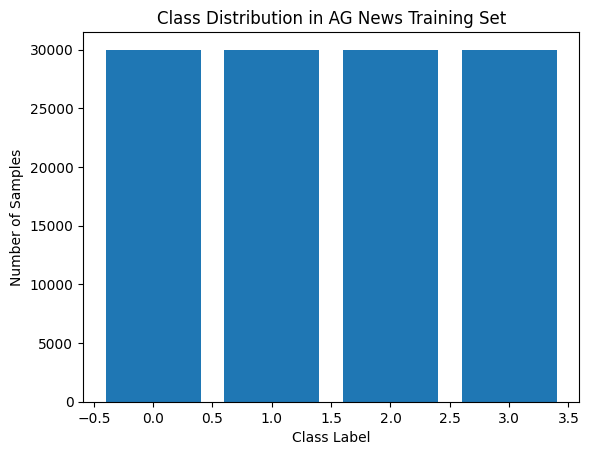

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Count samples per class
classes, counts = np.unique(y_train, return_counts=True)

plt.figure()
plt.bar(classes, counts)
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in AG News Training Set")
plt.show()

Text Lengths show typical document size  and variance

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stop_words and len(t) > 2]
    return " ".join(tokens)

X_train_clean = [clean_text(t) for t in X_train_text]
X_test_clean = [clean_text(t) for t in X_test_text]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


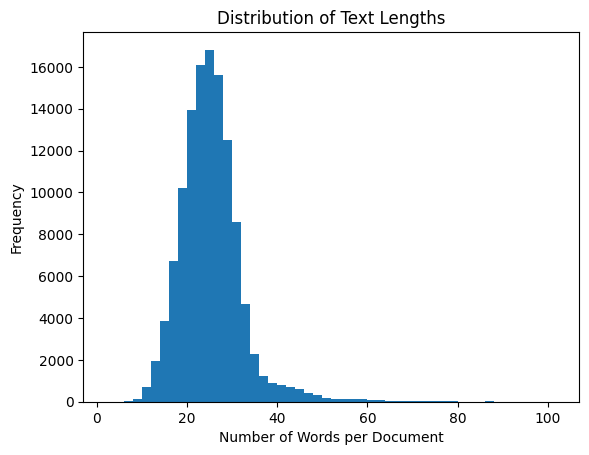

In [ ]:
# Compute text lengths (in words)
text_lengths = [len(text.split()) for text in X_train_clean]

plt.figure()
plt.hist(text_lengths, bins=50)
plt.xlabel("Number of Words per Document")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths")
plt.show()

Average length checks if some categories have longer or shorter texts

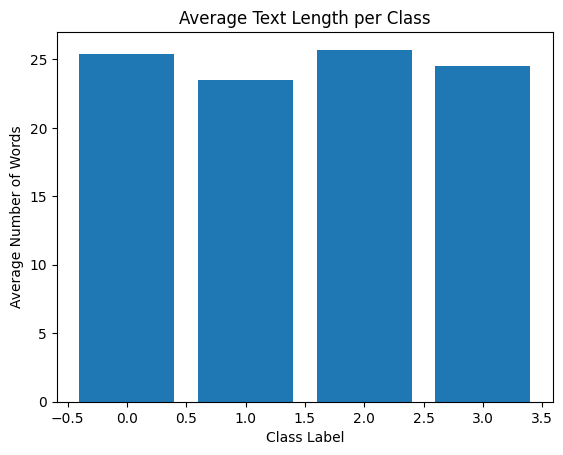

In [ ]:
# Compute average length per class
avg_lengths = []
for c in np.unique(y_train):
    class_texts = [X_train_clean[i] for i in range(len(X_train_clean)) if y_train.iloc[i] == c]
    class_lengths = [len(t.split()) for t in class_texts]
    avg_lengths.append(np.mean(class_lengths))

plt.figure()
plt.bar(np.unique(y_train), avg_lengths)
plt.xlabel("Class Label")
plt.ylabel("Average Number of Words")
plt.title("Average Text Length per Class")
plt.show()

This gives insight into the voabulary.

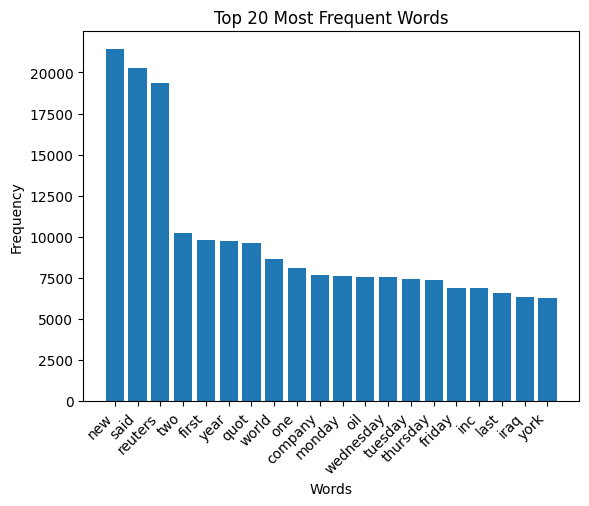

In [ ]:
from collections import Counter

# Count word frequencies
all_words = " ".join(X_train_clean).split()
word_counts = Counter(all_words)

# Get top N words
N = 20
most_common = word_counts.most_common(N)
words = [w for w, c in most_common]
counts = [c for w, c in most_common]

plt.figure()
plt.bar(words, counts)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title(f"Top {N} Most Frequent Words")
plt.xticks(rotation=45, ha="right")
plt.show()

## Embedding Strategies

## TF-IDF
TF-IDF produces fixed-length vectors, not sequences. A GRU, which is ordinal in nature, cannot exploit temporal structure here. Therefore, TF-IDF vectors are fed as a single timestep sequence. This is the baseline but theoretically mismatched to RNNs. TF-IDF turns each document into a fixed-length vector, each position corresponding to one word in the vocabulary. The value is a weight based on term frequency and Inverse Document Frequency. To combine TF-IDF with a GRU, eaxh document vector is therefore reshaped into a sequence. In this setting, the GRU behaves like a gated feedforward layer rather than a true sequence model.This is a good baseline as it allows us to quentify how much performance is gained using sequential dense embeddings that preserve word order.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=2000, dtype=np.float32)
X_train_tfidf = tfidf.fit_transform(X_train_clean).toarray()
X_test_tfidf = tfidf.transform(X_test_clean).toarray()

X_train_tfidf_seq = X_train_tfidf[:, None, :]
X_test_tfidf_seq = X_test_tfidf[:, None, :]

# reshape to (samples, timesteps=1, features)
X_train_tfidf_seq = X_train_tfidf[:, None, :]
X_test_tfidf_seq = X_test_tfidf[:, None, :]

In [ ]:
#Tokenization for word2vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 50000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_clean)

X_train_seq = tokenizer.texts_to_sequences(X_train_clean)
X_test_seq = tokenizer.texts_to_sequences(X_test_clean)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding="post")
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding="post")

word_index = tokenizer.word_index


In [ ]:
!pip install gensim
#train word2vec(CBOW vs skipgram)
from gensim.models import Word2Vec

sentences = [t.split() for t in X_train_clean]

# CBOW
w2v_cbow = Word2Vec(sentences, vector_size=100, window=5, min_count=2, sg=0)

# Skip-gram
w2v_sg = Word2Vec(sentences, vector_size=100, window=5, min_count=2, sg=1)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 80.0 MB/s eta 0:00:00


In [ ]:
#build embedding matrices
import numpy as np

def build_embedding_matrix(w2v_model, word_index, max_words, embed_dim):
    matrix = np.zeros((max_words, embed_dim))
    for word, i in word_index.items():
        if i < max_words and word in w2v_model.wv:
            matrix[i] = w2v_model.wv[word]
    return matrix

embed_dim = 100
embedding_matrix_cbow = build_embedding_matrix(w2v_cbow, word_index, max_words, embed_dim)
embedding_matrix_sg = build_embedding_matrix(w2v_sg, word_index, max_words, embed_dim)

## GRU Model Definition

### Model Architecture Description (GRU-based Text Classifier)

The proposed model is a **Gated Recurrent Unit (GRU)-based neural network** designed for multi-class text classification into four categories. It is implemented using the Keras Sequential API and supports two types of input representations: **TF-IDF features** and **pre-trained word embeddings**.

For the TF-IDF setting, the model directly applies a GRU layer to the input, which is treated as a single-timestep sequence of high-dimensional features. In this case, the GRU functions primarily as a gated nonlinear transformation rather than a true sequence model, since TF-IDF does not preserve word order.

For the embedding-based setting, the model begins with an **Embedding layer** initialized with a precomputed embedding matrix (e.g., Word2Vec CBOW or Skip-gram). This layer maps each token index to a dense vector representation and is kept frozen (non-trainable) to preserve the semantic structure learned from the corpus. The embedded token sequence is then processed by a **GRU layer** with a configurable number of hidden units, enabling the model to capture sequential and contextual dependencies in the text.

Following the GRU, a **Dropout layer** is applied for regularization to reduce overfitting. The final **Dense output layer** uses a softmax activation function to produce a probability distribution over the four target classes. The model is trained using the **Adam optimizer** with a tunable learning rate and optimized under the **sparse categorical cross-entropy** loss function, with classification accuracy used as the primary evaluation metric.

Overall, this architecture provides a flexible framework for comparing how different input representations—sparse TF-IDF vectors versus dense sequential word embeddings—interact with a GRU-based classifier in a multi-class text classification setting.




In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_gru_model(input_type, vocab_size=None, embed_dim=None, embedding_matrix=None, input_shape=None,
                    gru_units=128, dropout=0.3, lr=1e-3):

    model = Sequential()

    if input_type == "tfidf":
        model.add(GRU(gru_units, input_shape=input_shape))
    else:
        model.add(Embedding(
            input_dim=vocab_size,
            output_dim=embed_dim,
            weights=[embedding_matrix],
            trainable=False
        ))
        model.add(GRU(gru_units))

    model.add(Dropout(dropout))
    model.add(Dense(4, activation="softmax"))

    model.compile(
        optimizer=Adam(lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

## Training the 3 variants
We now train the GRU+TF-IDF, GRU+CBOW, and GRU+Skip-gram.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

In [ ]:
# GRU+TF-IDF
model_tfidf = build_gru_model(
    input_type="tfidf",
    input_shape=(1, X_train_tfidf_seq.shape[2]),
    gru_units=128,
    dropout=0.3
)

history_tfidf = model_tfidf.fit(
    X_train_tfidf_seq, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=64
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 28s 16ms/step - accuracy: 0.8436 - loss: 0.5883 - val_accuracy: 0.8841 - val_loss: 0.3231
Epoch 2/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.8919 - loss: 0.3169 - val_accuracy: 0.8822 - val_loss: 0.3228
Epoch 3/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8965 - loss: 0.3019 - val_accuracy: 0.8824 - val_loss: 0.3234
Epoch 4/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - accuracy: 0.8975 - loss: 0.2962 - val_accuracy: 0.8808 - val_loss: 0.3231
Epoch 5/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.8976 - loss: 0.2885 - val_accuracy: 0.8797 - val_loss: 0.3235
Epoch 6/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8997 - loss: 0.2826 - val_accuracy: 0.8810 - val_loss: 0.3187
Epoch 7/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9043 - loss: 0.2698 - val_accuracy: 0.8807 - val_loss: 0.3187
Epoch 8/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - accuracy: 0.9040 - loss:

The features here were greatly reduced due to memory constraints and the non-sequential nature of TF-IDF. When paired with TF-IDF, the GRU receives only a single timestep input, effectively reducing the recurrent model to a nonlinear feature classifier. The high accuracy (97.35%) reflects the strong discriminative power of TF-IDF features on AG News rather than genuine sequence modeling. This result serves as a strong baseline, but it does not exploit temporal word order.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

y_pred_probs = model_tfidf.predict(X_test_tfidf_seq)
y_pred = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")

print("Test Accuracy:", acc)
print("Macro F1:", f1_macro)
print("Weighted F1:", f1_weighted)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Test Accuracy: 0.8940789473684211
Macro F1: 0.8940302164685981
Weighted F1: 0.894030216468598

Classification Report:
               precision    recall  f1-score   support

           0     0.9174    0.8821    0.8994      1900
           1     0.9421    0.9595    0.9507      1900
           2     0.8620    0.8547    0.8584      1900
           3     0.8557    0.8800    0.8677      1900

    accuracy                         0.8941      7600
   macro avg     0.8943    0.8941    0.8940      7600
weighted avg     0.8943    0.8941    0.8940      7600



In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1676   63   94   67]
 [  29 1823   25   23]
 [  66   18 1624  192]
 [  56   31  141 1672]]


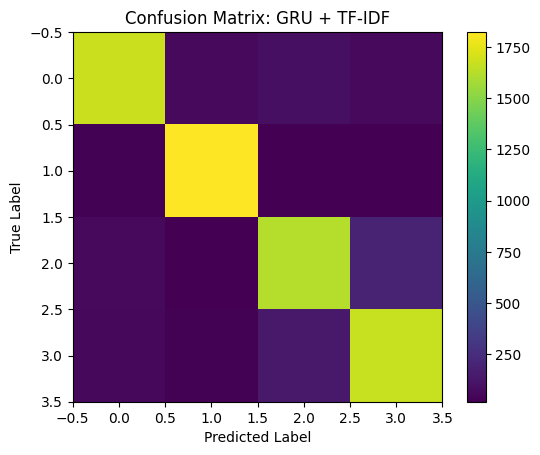

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix: GRU + TF-IDF")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
del model_tfidf
import gc; gc.collect()

0

In [ ]:
#GRU+CBOW
model_cbow = build_gru_model(
    input_type="w2v",
    vocab_size=max_words,
    embed_dim=embed_dim,
    embedding_matrix=embedding_matrix_cbow,
    gru_units=128,
    dropout=0.3
)

history_cbow = model_cbow.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 216s 125ms/step - accuracy: 0.2495 - loss: 1.3868 - val_accuracy: 0.2387 - val_loss: 1.3895
Epoch 2/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 196s 116ms/step - accuracy: 0.2709 - loss: 1.3529 - val_accuracy: 0.8820 - val_loss: 0.3226
Epoch 3/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 198s 117ms/step - accuracy: 0.8901 - loss: 0.3249 - val_accuracy: 0.8938 - val_loss: 0.2869
Epoch 4/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 209s 121ms/step - accuracy: 0.9049 - loss: 0.2758 - val_accuracy: 0.8969 - val_loss: 0.2767
Epoch 5/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 201s 119ms/step - accuracy: 0.9123 - loss: 0.2523 - val_accuracy: 0.8981 - val_loss: 0.2776
Epoch 6/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 210s 125ms/step - accuracy: 0.9216 - loss: 0.2257 - val_accuracy: 0.9019 - val_loss: 0.2748
Epoch 7/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 250s 117ms/step - accuracy: 0.9258 - loss: 0.2141 - val_accuracy: 0.9004 - val_loss: 0.2820
Epoch 8/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 205s 121ms/step - ac

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

y_pred_probs = model_cbow.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")

print("Test Accuracy:", acc)
print("Macro F1:", f1_macro)
print("Weighted F1:", f1_weighted)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

238/238 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step
Test Accuracy: 0.9036842105263158
Macro F1: 0.9035180664986295
Weighted F1: 0.9035180664986296

Classification Report:
               precision    recall  f1-score   support

           0     0.9062    0.9105    0.9084      1900
           1     0.9574    0.9695    0.9634      1900
           2     0.8668    0.8600    0.8634      1900
           3     0.8831    0.8747    0.8789      1900

    accuracy                         0.9037      7600
   macro avg     0.9034    0.9037    0.9035      7600
weighted avg     0.9034    0.9037    0.9035      7600



In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1730   47   71   52]
 [  25 1842   22   11]
 [  95   14 1634  157]
 [  59   21  158 1662]]


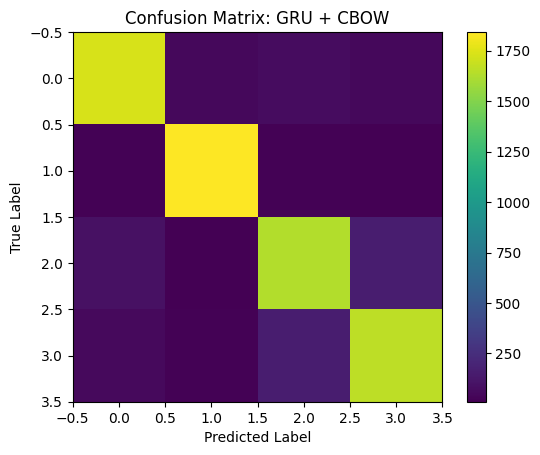

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix: GRU + CBOW")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
del model_cbow
import gc; gc.collect()

0

In [ ]:
#GRU+Skip-gram
model_sg = build_gru_model(
    input_type="w2v",
    vocab_size=max_words,
    embed_dim=embed_dim,
    embedding_matrix=embedding_matrix_sg,
    gru_units=128,
    dropout=0.3
)

history_sg = model_sg.fit(
    X_train_pad, y_train,
    validation_split=0.1,
    epochs=30,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 207s 122ms/step - accuracy: 0.2526 - loss: 1.3867 - val_accuracy: 0.2442 - val_loss: 1.3869
Epoch 2/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 206s 122ms/step - accuracy: 0.2484 - loss: 1.3863 - val_accuracy: 0.7033 - val_loss: 0.6433
Epoch 3/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 267s 125ms/step - accuracy: 0.8772 - loss: 0.3546 - val_accuracy: 0.9015 - val_loss: 0.2737
Epoch 4/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 209s 124ms/step - accuracy: 0.9070 - loss: 0.2715 - val_accuracy: 0.9097 - val_loss: 0.2504
Epoch 5/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 201s 119ms/step - accuracy: 0.9132 - loss: 0.2532 - val_accuracy: 0.9128 - val_loss: 0.2458
Epoch 6/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 199s 118ms/step - accuracy: 0.9175 - loss: 0.2382 - val_accuracy: 0.9138 - val_loss: 0.2405
Epoch 7/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 200s 118ms/step - accuracy: 0.9225 - loss: 0.2265 - val_accuracy: 0.9147 - val_loss: 0.2432
Epoch 8/30
1688/1688 ━━━━━━━━━━━━━━━━━━━━ 199s 118ms/step - ac

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

y_pred_probs = model_sg.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f1_weighted = f1_score(y_test, y_pred, average="weighted")

print("Test Accuracy:", acc)
print("Macro F1:", f1_macro)
print("Weighted F1:", f1_weighted)
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Test Accuracy: 0.9130263157894737
Macro F1: 0.9129036199575142
Weighted F1: 0.9129036199575142

Classification Report:
               precision    recall  f1-score   support

           0     0.9307    0.9042    0.9172      1900
           1     0.9632    0.9789    0.9710      1900
           2     0.8844    0.8621    0.8731      1900
           3     0.8742    0.9068    0.8902      1900

    accuracy                         0.9130      7600
   macro avg     0.9131    0.9130    0.9129      7600
weighted avg     0.9131    0.9130    0.9129      7600



In [ ]:
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Confusion Matrix:
 [[1718   51   84   47]
 [  17 1860   15    8]
 [  61    8 1638  193]
 [  50   12  115 1723]]


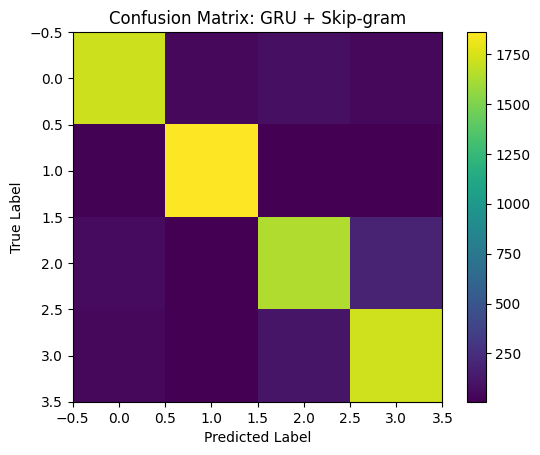

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(cm)
plt.title("Confusion Matrix: GRU + Skip-gram")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
plt.show()

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
del model_sg
import gc; gc.collect()

0

##Hyperparameter tuning

In [ ]:
configs = [
    {"gru_units": 64, "dropout": 0.3, "lr": 1e-3},
    {"gru_units": 128, "dropout": 0.3, "lr": 1e-3},
    {"gru_units": 128, "dropout": 0.5, "lr": 1e-3},
]

results = []

for cfg in configs:
    model = build_gru_model(
        input_type="w2v",
        vocab_size=max_words,
        embed_dim=embed_dim,
        embedding_matrix=embedding_matrix_sg,
        gru_units=cfg["gru_units"],
        dropout=cfg["dropout"],
        lr=cfg["lr"]
    )
    hist = model.fit(X_train_pad, y_train, validation_split=0.1, epochs=30, batch_size=64, verbose=0, callbacks=[early_stop])
    val_acc = max(hist.history["val_accuracy"])
    results.append((cfg, val_acc))

print(results)

[({'gru_units': 64, 'dropout': 0.3, 'lr': 0.001}, 0.9138333201408386), ({'gru_units': 128, 'dropout': 0.3, 'lr': 0.001}, 0.9136666655540466), ({'gru_units': 128, 'dropout': 0.5, 'lr': 0.001}, 0.9142500162124634)]


In [ ]:
configs = [
    {"gru_units": 64, "dropout": 0.3, "lr": 1e-3},
    {"gru_units": 128, "dropout": 0.3, "lr": 1e-3},
    {"gru_units": 128, "dropout": 0.5, "lr": 1e-3},
]

results = []

for cfg in configs:
    model = build_gru_model(
        input_type="w2v",
        vocab_size=max_words,
        embed_dim=embed_dim,
        embedding_matrix=embedding_matrix_cbow,
        gru_units=cfg["gru_units"],
        dropout=cfg["dropout"],
        lr=cfg["lr"]
    )
    hist = model.fit(X_train_pad, y_train, validation_split=0.1, epochs=30, batch_size=64, verbose=0, callbacks=[early_stop])
    val_acc = max(hist.history["val_accuracy"])
    results.append((cfg, val_acc))

print(results)

[({'gru_units': 64, 'dropout': 0.3, 'lr': 0.001}, 0.9035833477973938), ({'gru_units': 128, 'dropout': 0.3, 'lr': 0.001}, 0.9043333530426025), ({'gru_units': 128, 'dropout': 0.5, 'lr': 0.001}, 0.9042500257492065)]


## Results and Discussion
## 3 variants
| Model               | Accuracy   | Precision (Macro) | Recall (Macro) | F1-Score (Macro) |
| ------------------- | ---------- | ----------------- | -------------- | ---------------- |
| **GRU + TF-IDF**    | **0.8941** | **0.8943**        | **0.8941**     | **0.8940**       |
| **GRU + CBOW**      | **0.9037** | **0.9034**        | **0.9037**     | **0.9035**       |
| **GRU + Skip-gram** | **0.9130** | **0.9131**        | **0.9130**     | **0.9129**       |



## Hyperparameter Tuning(CBOW)

| GRU Units | Dropout | LR   | Val Accuracy |
| --------- | ------- | ---- | ------------ |
| 64        | 0.3     | 1e-3 | **0.9036**   |
| 128       | 0.3     | 1e-3 | **0.9043**   |
| 128       | 0.5     | 1e-3 | **0.9043**   |


## Hyperparameter Tuning(Skip-gram)

| GRU Units | Dropout | LR   | Val Accuracy |
| --------- | ------- | ---- | ------------ |
| 64        | 0.3     | 1e-3 | **0.9138**   |
| 128       | 0.3     | 1e-3 | **0.9137**   |
| 128       | 0.5     | 1e-3 | **0.9143**   |
